In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from transformers import AutoModelForCausalLM
from run_eval import TimeMoE, BenchmarkEvalDataset, MSEMetric, MAEMetric, DataLoader, evaluate
import argparse

/home/aaburkova_1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Load pretrained TimeMoE
model1 = TimeMoE(
    'Maple728/TimeMoE-50M',
    'cpu',
    context_length=192,
    prediction_length=4,
)

device = torch.device("cpu")


batch_size = 32
context_length = 192  # e.g. your setting
prediction_length = 48


/home/aaburkova_1/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Found MoE layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Using MoE layer: 11
router_logits: torch.Size([6144, 8])
moe_output: torch.Size([32, 192, 384])


/home/aaburkova_1/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


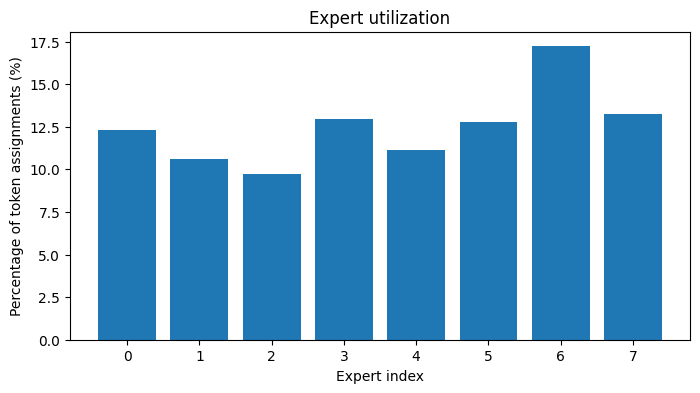

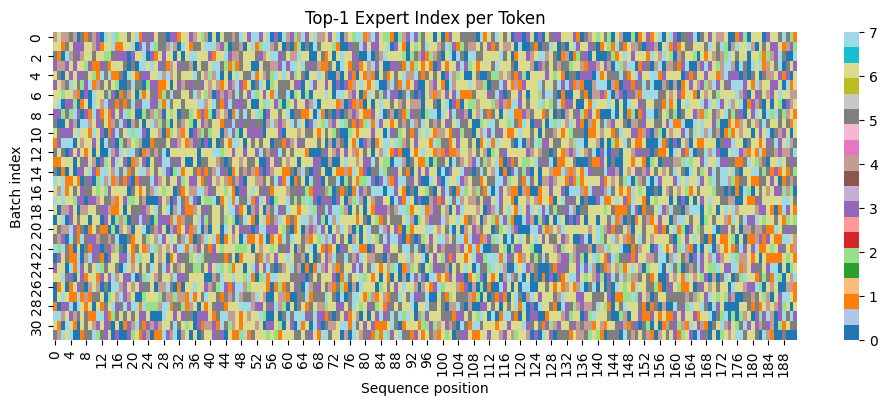

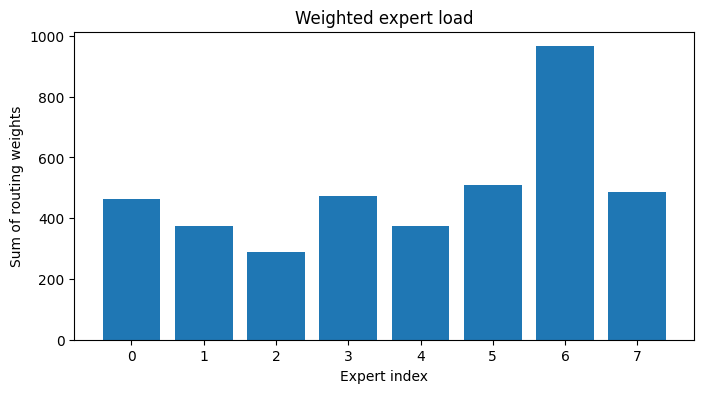

In [21]:
moe_layers = []
for i, layer in enumerate(model1.model.model.layers):

    from time_moe.models.modeling_time_moe import TimeMoeSparseExpertsLayer
    if isinstance(layer.ffn_layer, TimeMoeSparseExpertsLayer):
        moe_layers.append((i, layer.ffn_layer))

print("Found MoE layers:", [n for n, _ in moe_layers])
assert len(moe_layers) > 0, "No MoE layers found — check the module path"

moe_name, moe_layer = moe_layers[-1]
print("Using MoE layer:", moe_name)


param = next(moe_layer.parameters())
target_dtype = param.dtype 
target_device = param.device


dummy_hidden = torch.randn(batch_size, context_length, moe_layer.gate.in_features,
                           device=target_device, dtype=target_dtype)

moe_layer.eval()
with torch.no_grad():
    moe_output, router_logits = moe_layer(dummy_hidden)


print("router_logits:", router_logits.shape)
print("moe_output:", moe_output.shape)


bs, sl = batch_size, context_length
num_experts = moe_layer.num_experts

routing_probs = F.softmax(router_logits, dim=-1)
top_k = moe_layer.top_k
routing_weights, selected_experts = torch.topk(routing_probs, top_k, dim=-1)

# (a) Expert usage count (how many times each expert was selected)
all_selected = selected_experts.view(-1)
expert_usage = torch.bincount(all_selected, minlength=num_experts).float()
usage_percent = expert_usage / expert_usage.sum() * 100

plt.figure(figsize=(8, 4))
plt.bar(range(num_experts), usage_percent.cpu().numpy())
plt.xlabel("Expert index")
plt.ylabel("Percentage of token assignments (%)")
plt.title("Expert utilization")
plt.show()

# (b) Token → expert map (top-1 only) as heatmap
top1 = selected_experts[:, 0].view(batch_size, sl).cpu().numpy()

plt.figure(figsize=(12, 4))
sns.heatmap(top1, cmap="tab20", cbar=True)
plt.xlabel("Sequence position")
plt.ylabel("Batch index")
plt.title("Top-1 Expert Index per Token")
plt.show()

# (c) Weighted expert load (sum of routing weights for each expert)
# For each token, sum its routing weight contribution to each expert
# But we only have routing_weights for top_k — we need to map them to global expert indices
routing_weights = routing_weights.to(torch.float32)
selected_experts = selected_experts.to(torch.long)

weighted_load = torch.zeros(num_experts, device=routing_weights.device, dtype=routing_weights.dtype)

for i in range(top_k):
    idx = selected_experts[:, i]
    w = routing_weights[:, i]
    weighted_load = weighted_load.index_add(0, idx, w)

plt.figure(figsize=(8, 4))
plt.bar(range(num_experts), weighted_load.float().cpu().numpy())
plt.xlabel("Expert index")
plt.ylabel("Sum of routing weights")
plt.title("Weighted expert load")
plt.show()

Exctracting some more data

In [8]:
# data = 'dataset/ETT-small/E0.csv'

# is_dist = False

# # evaluation
# metric_list = [
#     MSEMetric(name='mse'),
#     MAEMetric(name='mae'),
# ]


# dataset = BenchmarkEvalDataset(
#     data,
#     context_length=context_length,
#     prediction_length=prediction_length,
# )


# sampler = None
# test_dl = DataLoader(
#     dataset=dataset,
#     batch_size=batch_size,
#     sampler=sampler,
#     shuffle=False,
#     num_workers=2,
#     prefetch_factor=2,
#     drop_last=False,
# )

# acc_count = 0
# with torch.no_grad():
#     for idx, batch in enumerate(tqdm(test_dl)):
#         preds, labels = model.predict(batch)

#         for metric in metric_list:
#             metric.push(preds, labels)

#         acc_count += count_num_tensor_elements(preds)

# ret_metric = {}
# for metric in metric_list:
#     ret_metric[metric.name] = metric.value / acc_count
# print(f'{0} - {ret_metric}')

# metric_tensors = [metric.value for metric in metric_list] + [acc_count]


In [4]:
import json
import os
import argparse
import numpy as np
import logging
import torch
import torch.distributed as dist
from torch.utils.data import DistributedSampler, DataLoader
from tqdm import tqdm

from transformers import AutoModelForCausalLM

from time_moe.datasets.benchmark_dataset import BenchmarkEvalDataset, GeneralEvalDataset

def setup_nccl(rank, world_size, master_addr='127.0.0.1', master_port=9899):
    dist.init_process_group("nccl", init_method='tcp://{}:{}'.format(master_addr, master_port), rank=rank,
                            world_size=world_size)


def count_num_tensor_elements(tensor):
    n = 1
    for s in tensor.shape:
        n = n * s
    return n


# ------------------ Metrics ------------------
class SumEvalMetric:
    def __init__(self, name, init_val: float = 0.0):
        self.name = name
        self.value = init_val

    def push(self, preds, labels, **kwargs):
        self.value += self._calculate(preds, labels, **kwargs)

    def _calculate(self, preds, labels, **kwargs):
        pass


class MSEMetric(SumEvalMetric):
    def _calculate(self, preds, labels, **kwargs):
        return torch.sum((preds - labels) ** 2)


class MAEMetric(SumEvalMetric):
    def _calculate(self, preds, labels, **kwargs):
        return torch.sum(torch.abs(preds - labels))


class TimeMoE:
    def __init__(self, model_path, device, context_length, prediction_length, **kwargs):
        try:
            from time_moe.models.modeling_time_moe import TimeMoeForPrediction
            model = TimeMoeForPrediction.from_pretrained(
                model_path,
                device_map=device,
                # attn_implementation='flash_attention_2',
                torch_dtype='auto',
            )
        except:
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                device_map=device,
                # attn_implementation='flash_attention_2',
                torch_dtype='auto',
                trust_remote_code=True,
            )

        logging.info(f'>>> Model dtype: {model.dtype}; Attention:{model.config._attn_implementation}')

        self.model = model
        self.device = device
        self.prediction_length = prediction_length
        self.model.eval()

    def predict(self, batch):
        model = self.model
        device = self.device
        prediction_length = self.prediction_length

        outputs = model.generate(
            inputs=batch['inputs'].to(device).to(model.dtype),
            max_new_tokens=prediction_length,
        )
        preds = outputs[:, -prediction_length:]
        labels = batch['labels'].to(device)
        if len(preds.shape) > len(labels.shape):
            labels = labels[..., None]
        return preds, labels


def evaluate(args):
    batch_size = args.batch_size
    context_length = args.context_length
    prediction_length = args.prediction_length

    master_addr = os.getenv('MASTER_ADDR', '127.0.0.1')
    master_port = os.getenv('MASTER_PORT', 9899)
    world_size = int(os.getenv('WORLD_SIZE') or 1)
    rank = int(os.getenv('RANK') or 0)
    local_rank = int(os.getenv('LOCAL_RANK') or 0)
    if torch.cuda.is_available():
        try:
            setup_nccl(rank=rank, world_size=world_size, master_addr=master_addr, master_port=master_port)
            device = f"cuda:{local_rank}"
            is_dist = True
        except Exception as e:
            print('Error: ', f'Setup nccl fail, so set device to cpu: {e}')
            device = 'cpu'
            is_dist = False
    else:
        device = 'cpu'
        is_dist = False

    # evaluation
    metric_list = [
        MSEMetric(name='mse'),
        MAEMetric(name='mae'),
    ]

    model = TimeMoE(
        args.model,
        device,
        context_length=context_length,
        prediction_length=prediction_length
    )
    if args.data.endswith('.csv'):
        dataset = BenchmarkEvalDataset(
            args.data,
            context_length=context_length,
            prediction_length=prediction_length,
        )
    else:
        dataset = GeneralEvalDataset(
            args.data,
            context_length=context_length,
            prediction_length=prediction_length,
        )

    if torch.cuda.is_available() and dist.is_initialized():
        sampler = DistributedSampler(dataset=dataset, shuffle=False)
    else:
        sampler = None
    test_dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=sampler,
        shuffle=False,
        num_workers=2,
        prefetch_factor=2,
        drop_last=False,
    )

    acc_count = 0
    predictions = []
    labelss = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(test_dl)):
            preds, labels = model.predict(batch)
            predictions.append(preds)
            labelss.append(labels)

            for metric in metric_list:
                metric.push(preds, labels)

            acc_count += count_num_tensor_elements(preds)

    ret_metric = {}
    for metric in metric_list:
        ret_metric[metric.name] = metric.value / acc_count
    print(f'{rank} - {ret_metric}')

    metric_tensors = [metric.value for metric in metric_list] + [acc_count]
    if is_dist:
        stat_tensor = torch.tensor(metric_tensors).to(model.device)
        gathered_results = [torch.zeros_like(stat_tensor) for _ in range(world_size)]
        dist.all_gather(gathered_results, stat_tensor)
        all_stat = torch.stack(gathered_results, dim=0).sum(dim=0)
    else:
        all_stat = metric_tensors

    if rank == 0:
        item = {
            'model': args.model,
            'data': args.data,
            'context_length': args.context_length,
            'prediction_length': args.prediction_length,
        }

        count = all_stat[-1]
        for i, metric in enumerate(metric_list):
            val = all_stat[i] / count
            item[metric.name] = float(val.cpu().numpy())
        logging.info(item)
    return predictions, labelss

In [5]:
parser = argparse.ArgumentParser('TimeMoE Evaluate')
args = parser.parse_args(args=[])
args.data = 'dataset/AAPL_prices.csv'
args.model = 'Maple728/TimeMoE-50M'
args.batch_size = 32
args.prediction_length = 48
args.context_length = None
if args.context_length is None:
    if args.prediction_length == 96:
        args.context_length = 512
    elif args.prediction_length == 192:
        args.context_length = 1024
    elif args.prediction_length == 336:
        args.context_length = 2048
    elif args.prediction_length == 720:
        args.context_length = 3072
    else:
        args.context_length = args.prediction_length * 4
preds, labs = evaluate(args)

2025-10-20 22:22:06,356 - log_util.py[pid:76627;line:52:log_in_local_rank_0] - INFO: >>> Split test data from 2022-11-01 to 2024-12-31, and evaluation start date is: 2023-08-09


  0%|          | 0/48 [00:00<?, ?it/s]/home/aaburkova_1/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 48/48 [04:30<00:00,  5.63s/it]


0 - {'mse': tensor(0.3444), 'mae': tensor(0.4411)}


In [10]:
labs[-1].shape

torch.Size([16, 48])

Found MoE layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Using MoE layer: 11
router_logits: torch.Size([6144, 8])
moe_output: torch.Size([32, 192, 384])


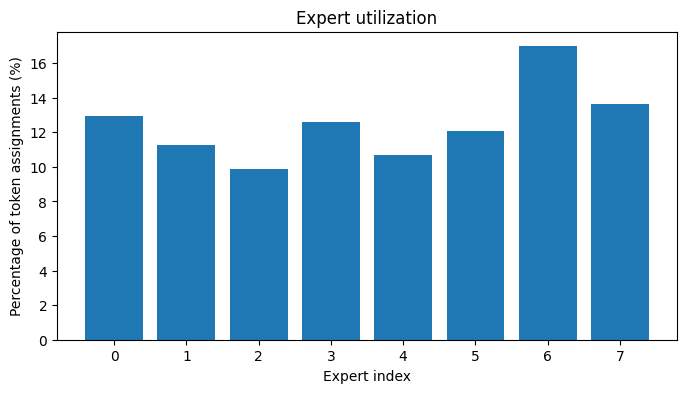

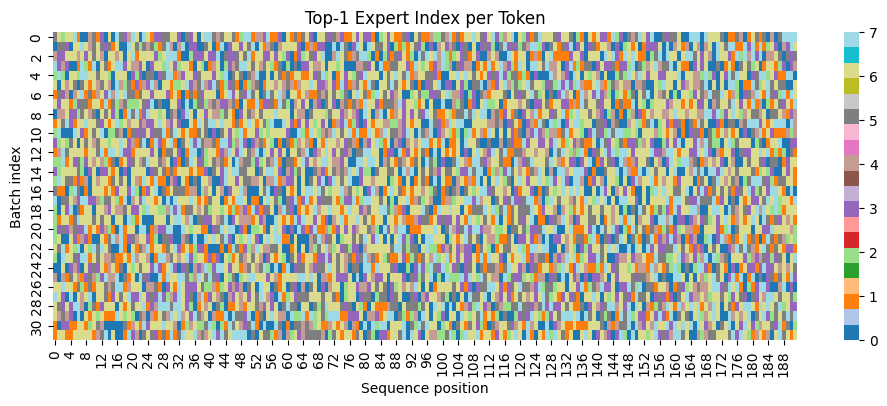

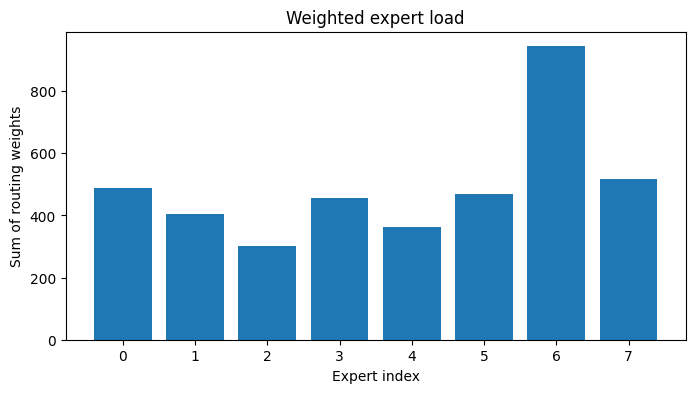

In [19]:
moe_layers = []
for i, layer in enumerate(model.model.model.layers):

    from time_moe.models.modeling_time_moe import TimeMoeSparseExpertsLayer
    if isinstance(layer.ffn_layer, TimeMoeSparseExpertsLayer):
        moe_layers.append((i, layer.ffn_layer))

print("Found MoE layers:", [n for n, _ in moe_layers])
assert len(moe_layers) > 0, "No MoE layers found — check the module path"

moe_name, moe_layer = moe_layers[-1]
print("Using MoE layer:", moe_name)


param = next(moe_layer.parameters())
target_dtype = param.dtype 
target_device = param.device


dummy_hidden = torch.randn(batch_size, context_length, moe_layer.gate.in_features,
                           device=target_device, dtype=target_dtype)

moe_layer.eval()
with torch.no_grad():
    moe_output, router_logits = moe_layer(dummy_hidden)


print("router_logits:", router_logits.shape)
print("moe_output:", moe_output.shape)


bs, sl = batch_size, context_length
num_experts = moe_layer.num_experts

routing_probs = F.softmax(router_logits, dim=-1)
top_k = moe_layer.top_k
routing_weights, selected_experts = torch.topk(routing_probs, top_k, dim=-1)

# (a) Expert usage count (how many times each expert was selected)
all_selected = selected_experts.view(-1)
expert_usage = torch.bincount(all_selected, minlength=num_experts).float()
usage_percent = expert_usage / expert_usage.sum() * 100

plt.figure(figsize=(8, 4))
plt.bar(range(num_experts), usage_percent.cpu().numpy())
plt.xlabel("Expert index")
plt.ylabel("Percentage of token assignments (%)")
plt.title("Expert utilization")
plt.show()

# (b) Token → expert map (top-1 only) as heatmap
top1 = selected_experts[:, 0].view(batch_size, sl).cpu().numpy()

plt.figure(figsize=(12, 4))
sns.heatmap(top1, cmap="tab20", cbar=True)
plt.xlabel("Sequence position")
plt.ylabel("Batch index")
plt.title("Top-1 Expert Index per Token")
plt.show()

# (c) Weighted expert load (sum of routing weights for each expert)
# For each token, sum its routing weight contribution to each expert
# But we only have routing_weights for top_k — we need to map them to global expert indices
routing_weights = routing_weights.to(torch.float32)
selected_experts = selected_experts.to(torch.long)

weighted_load = torch.zeros(num_experts, device=routing_weights.device, dtype=routing_weights.dtype)

for i in range(top_k):
    idx = selected_experts[:, i]
    w = routing_weights[:, i]
    weighted_load = weighted_load.index_add(0, idx, w)

plt.figure(figsize=(8, 4))
plt.bar(range(num_experts), weighted_load.float().cpu().numpy())
plt.xlabel("Expert index")
plt.ylabel("Sum of routing weights")
plt.title("Weighted expert load")
plt.show()

In [24]:
from huggingface_hub import snapshot_download
import os

repo_id = "Maple728/Time-300B"
local_dir = "data/finance"

dataset_path = snapshot_download(
    repo_id=repo_id,
    repo_type="dataset",
    allow_patterns=["finance*"],
    local_dir=local_dir,
    local_dir_use_symlinks=False,
    resume_download=True,
)

print("✅ Dataset downloaded to:", dataset_path)

# List the files
for root, _, files in os.walk(dataset_path):
    for f in files:
        print(" -", os.path.join(root, f))



/home/aaburkova_1/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/aaburkova_1/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 20 files: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]

✅ Dataset downloaded to: /home/aaburkova_1/Time-MoE/data/finance
 - /home/aaburkova_1/Time-MoE/data/finance/finance/bitcoin_with_missing/data-1-of-1.bin
 - /home/aaburkova_1/Time-MoE/data/finance/finance/bitcoin_with_missing/meta.json
 - /home/aaburkova_1/Time-MoE/data/finance/finance/cif_2016_6/data-1-of-1.bin
 - /home/aaburkova_1/Time-MoE/data/finance/finance/cif_2016_6/meta.json
 - /home/aaburkova_1/Time-MoE/data/finance/finance/cif_2016_12/data-1-of-1.bin
 - /home/aaburkova_1/Time-MoE/data/finance/finance/cif_2016_12/meta.json
 - /home/aaburkova_1/Time-MoE/data/finance/finance/tourism_yearly/data-1-of-1.bin
 - /home/aaburkova_1/Time-MoE/data/finance/finance/tourism_yearly/meta.json
 - /home/aaburkova_1/Time-MoE/data/finance/finance/tourism_quarterly/data-1-of-1.bin
 - /home/aaburkova_1/Time-MoE/data/finance/finance/tourism_quarterly/meta.json
 - /home/aaburkova_1/Time-MoE/data/finance/finance/nn5_daily_with_missing/data-1-of-1.bin
 - /home/aaburkova_1/Time-MoE/data/finance/finance/

In [12]:
import numpy as np
import pandas as pd

file_path = "data/finance/finance/bitcoin_with_missing/data-1-of-1.bin"

arr = np.fromfile(file_path, dtype=np.float32)
print("Loaded", arr.shape[0], "float32 values")
print(arr[:20])



Loaded 68927 float32 values
[ 1.015625  7.015625 10.015625 20.015625 18.       16.015625 18.
 16.015625 22.015625 21.015625 22.015625 12.03125  18.       22.015625
 14.015625 17.015625  8.015625 23.015625 24.015625 23.015625]


In [44]:
import yfinance as yf
import numpy as np
data = yf.download('AAPL', start="2018-01-01", end="2025-01-01")
data.reset_index()

/tmp/ipykernel_172124/1106963102.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2018-01-02,40.380997,40.390375,39.677740,39.888719,102223600
1,2018-01-03,40.373962,40.917816,40.310672,40.444289,118071600
2,2018-01-04,40.561497,40.664642,40.338800,40.446630,89738400
3,2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
4,2018-01-08,40.870937,41.166304,40.772478,40.870937,82271200
...,...,...,...,...,...,...
1756,2024-12-24,257.286652,257.296596,254.386927,254.586231,23234700
1757,2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100
1758,2024-12-27,254.685883,257.784897,252.164833,256.917949,42355300


In [45]:
df = pd.DataFrame(data.reset_index().values, columns=['date', 'Close', 'Open', 'Low', 'High', 'Volume'])
df

,date,Close,Open,Low,High,Volume
0,2018-01-02,40.380997,40.390375,39.67774,39.888719,102223600
1,2018-01-03,40.373962,40.917816,40.310672,40.444289,118071600
2,2018-01-04,40.561497,40.664642,40.3388,40.44663,89738400
3,2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
4,2018-01-08,40.870937,41.166304,40.772478,40.870937,82271200
...,...,...,...,...,...,...
1756,2024-12-24,257.286652,257.296596,254.386927,254.586231,23234700
1757,2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100
1758,2024-12-27,254.685883,257.784897,252.164833,256.917949,42355300
1759,2024-12-30,251.307877,252.603281,249.863009,251.337769,35557500


In [52]:
df.to_csv('dataset/AAPL_prices.csv', index=False)

In [41]:
model = TimeMoE(
    "Maple728/TimeMoE-50M",
    device="cpu",
    context_length=48*4,   # e.g. last 4 weeks of data (48 days)
    prediction_length=7,   # forecast for next 7 days
)

# # Example: get recent historical returns of a stock

# Get the last 192 days as context
context = torch.tensor(returns.values.flatten()[-192:], dtype=torch.float32).unsqueeze(0)  # (1, 192)

# Run prediction
with torch.no_grad():
    forecast = model.predict(context)  # shape: (7,) for next 7 days

print("Forecasted returns for next 7 days:", forecast)


IndexError: too many indices for tensor of dimension 2